In [2]:
import numpy as np
import astropy.convolution as cnv
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import warnings
from astropy.stats import circmean
from astropy.convolution import convolve, convolve_fft
import astropy.convolution as cnv
from skimage.morphology import disk
import random
import os
import spikeinterface.extractors as se
import pandas as pd
import matplotlib.pyplot as plt
def get_ratemaps(spikes, x, y, n: int, binsize = 15, stddev = 5, frame_rate = 25):
    """
    Calculate the rate map for given spikes and positions.

    Args:
        spikes (array): spike train for unit
        x (array): x positions of animal
        y (array): y positions of animal
        n (int): kernel size for convolution
        binsize (int, optional): binning size of x and y data. Defaults to 15.
        stddev (int, optional): gaussian standard deviation. Defaults to 5.

    Returns:
        rmap: 2D array of rate map
        x_edges: edges of x bins
        y_edges: edges of y bins
    """
    x_bins = np.arange(np.nanmin(x), np.nanmax(x) + binsize, binsize)
    y_bins = np.arange(np.nanmin(y), np.nanmax(y)+ binsize, binsize)

    pos_binned, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])
    pos_binned = pos_binned/frame_rate
    spikes = [np.int32(el) for el in spikes]
    
    spikes_x = x[spikes]
    spikes_y = y[spikes]
    spikes_binned, _, _ = np.histogram2d(spikes_x, spikes_y, bins=[x_bins, y_bins])
    

    g = cnv.Gaussian2DKernel(stddev, x_size=n, y_size=n)
    g = np.array(g)
    smoothed_spikes =cnv.convolve(spikes_binned, g)
    smoothed_pos = cnv.convolve(pos_binned, g)

    rmap = np.divide(
        smoothed_spikes,
        smoothed_pos,
        out=np.full_like(smoothed_spikes, np.nan),  
        where=smoothed_pos != 0              
    )

    rmap_unsmoothed = np.divide(
        spikes_binned,
        pos_binned,
        out=np.full_like(spikes_binned, np.nan),
        where=pos_binned != 0
    )
    return rmap, x_edges, y_edges, pos_binned, spikes_binned, smoothed_pos, smoothed_spikes, rmap_unsmoothed




This code lets us play around with the ratemaps and look at the smoothed and smoothed position and spikes maps

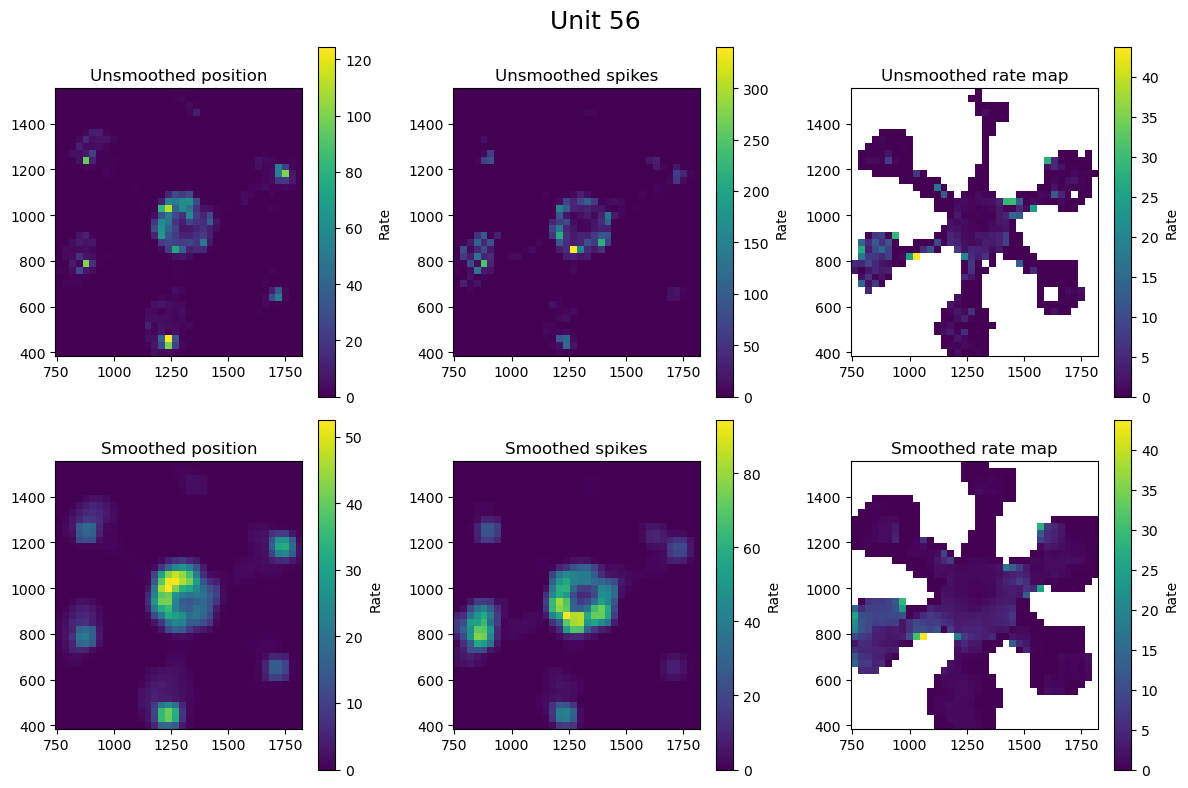

In [17]:
derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-003_id_2V\ses-01_date-30072025\all_trials"
unit_id = 56

frame_rate = 25
sample_rate = 30000
kilosort_output_path = os.path.join(derivatives_base,  "concat_run","sorting", "sorter_output" )
sorting = se.read_kilosort(
    folder_path = kilosort_output_path
)
unit_ids = sorting.unit_ids
labels = sorting.get_property('KSLabel')

# Get directory for the positional data
pos_data_path = os.path.join(derivatives_base, 'analysis', 'spatial_behav_data', 'XY_and_HD', 'XY_HD_alltrials.csv')
pos_data = pd.read_csv(pos_data_path)

x = pos_data.iloc[:, 0].to_numpy()
y = pos_data.iloc[:, 1].to_numpy()
hd = pos_data.iloc[:, 2].to_numpy()


# Load spike data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.round(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train = [np.int32(el) for el in spike_train if el < len(x)]  # Ensure spike train is within bounds of x and y
# Make plot
fig, axs = plt.subplots(2, 3, figsize = [12, 8])
axs = axs.flatten()
fig.suptitle(f"Unit {unit_id}", fontsize = 18)


# Plot ratemap
rmap, x_edges, y_edges, binned_pos, binned_spikes, smoothed_pos, smoothed_spikes, rmap_unsmoothed = get_ratemaps(spike_train, x, y, 3, binsize=30, stddev=5)

data_array = [binned_pos, binned_spikes, rmap_unsmoothed, smoothed_pos, smoothed_spikes, rmap]
titles = ['Unsmoothed position', 'Unsmoothed spikes', 'Unsmoothed rate map', 'Smoothed position', 'Smoothed spikes', 'Smoothed rate map']

for counter in np.arange(0,6):
        im = axs[counter].imshow(data_array[counter].T, 
        cmap='viridis', 
        interpolation = None,
        origin='lower', 
        aspect='auto', 
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

        axs[counter].set_title(f"n = {len(spike_train)}")
        axs[counter].set_aspect('equal')
        axs[counter].set_title(titles[counter])
        fig.colorbar(im, ax=axs[counter], label='Rate')
plt.tight_layout()
plt.show()